# Определение температуры стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Целью данного проекта является построение модели, которая предскажет температуру стали.
В качестве целевой метрики используется MAE

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

## 1. Обзор и исследование данных

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time, datetime
pd.options.mode.chained_assignment = None

from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


### данные об электродах (data_arc.csv)

In [3]:
# напишем функцию для загрузки данных
def load_file(pth):
    pth1 = f'/datasets/final_steel/{pth}'
    pth2 = f'.\{pth}' 
    if os.path.exists(pth1):
        return pd.read_csv(pth1)
    elif os.path.exists(pth2):
        return pd.read_csv(pth2)
    else:
        print('Something is wrong')

In [4]:
data_arc = load_file('data_arc.csv')
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
# проверим данные на наличие явных дубликатов
data_arc.duplicated().sum()

0

In [7]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


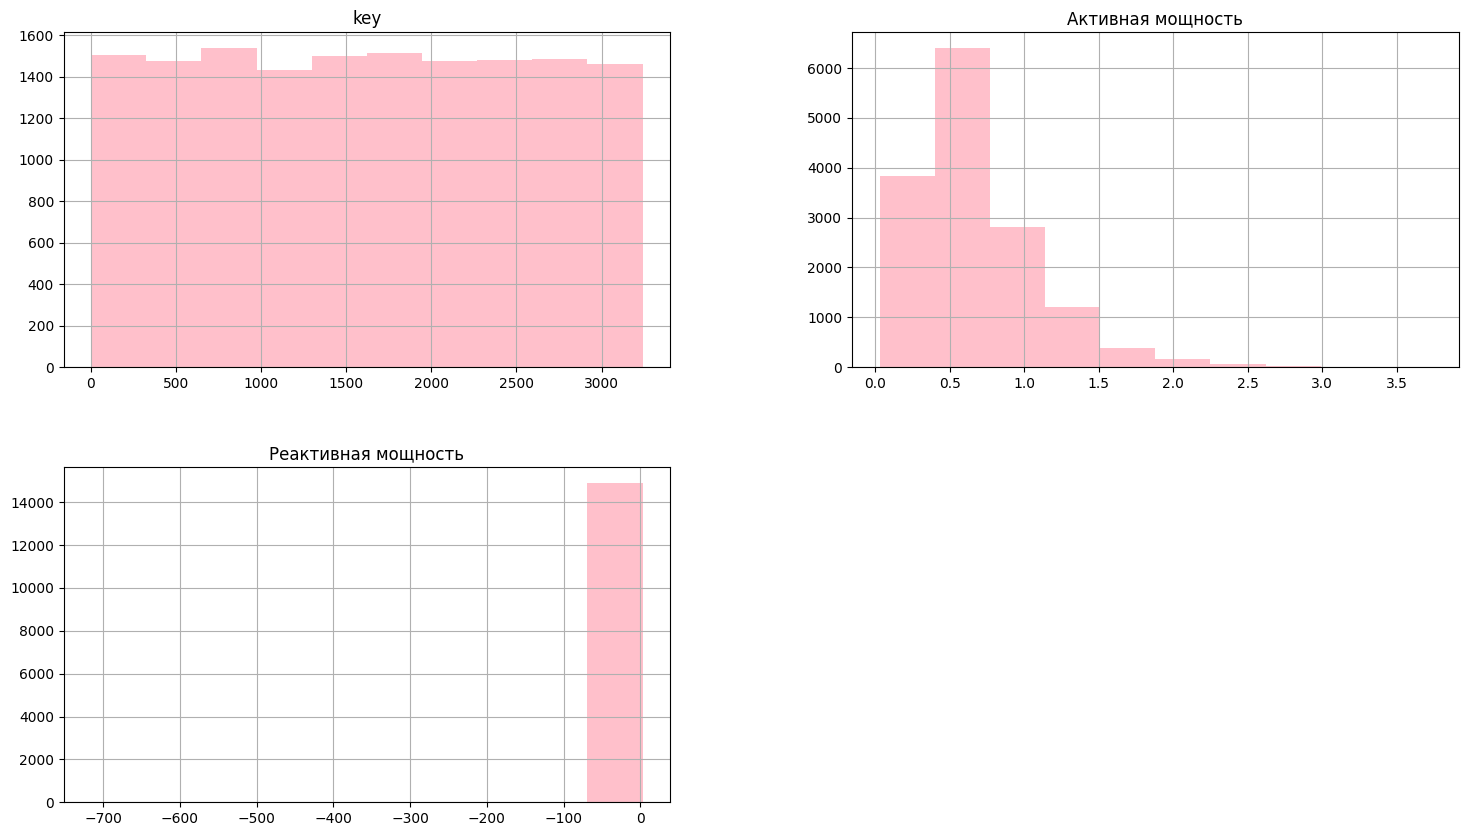

In [8]:
data_arc.hist(figsize=(18, 10), color = 'pink');

Мы видим, что в значениях реактивной мощности присутствуют аномальные отрицательные значения, удалим их во время предобработки данных. 

###  данные о подаче сыпучих материалов (объём) (data_bulk.csv)

In [9]:
data_bulk = load_file('data_bulk.csv')
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [10]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [11]:
# проверим данные на наличие явных дубликатов
data_bulk.duplicated().sum()

0

In [12]:
data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


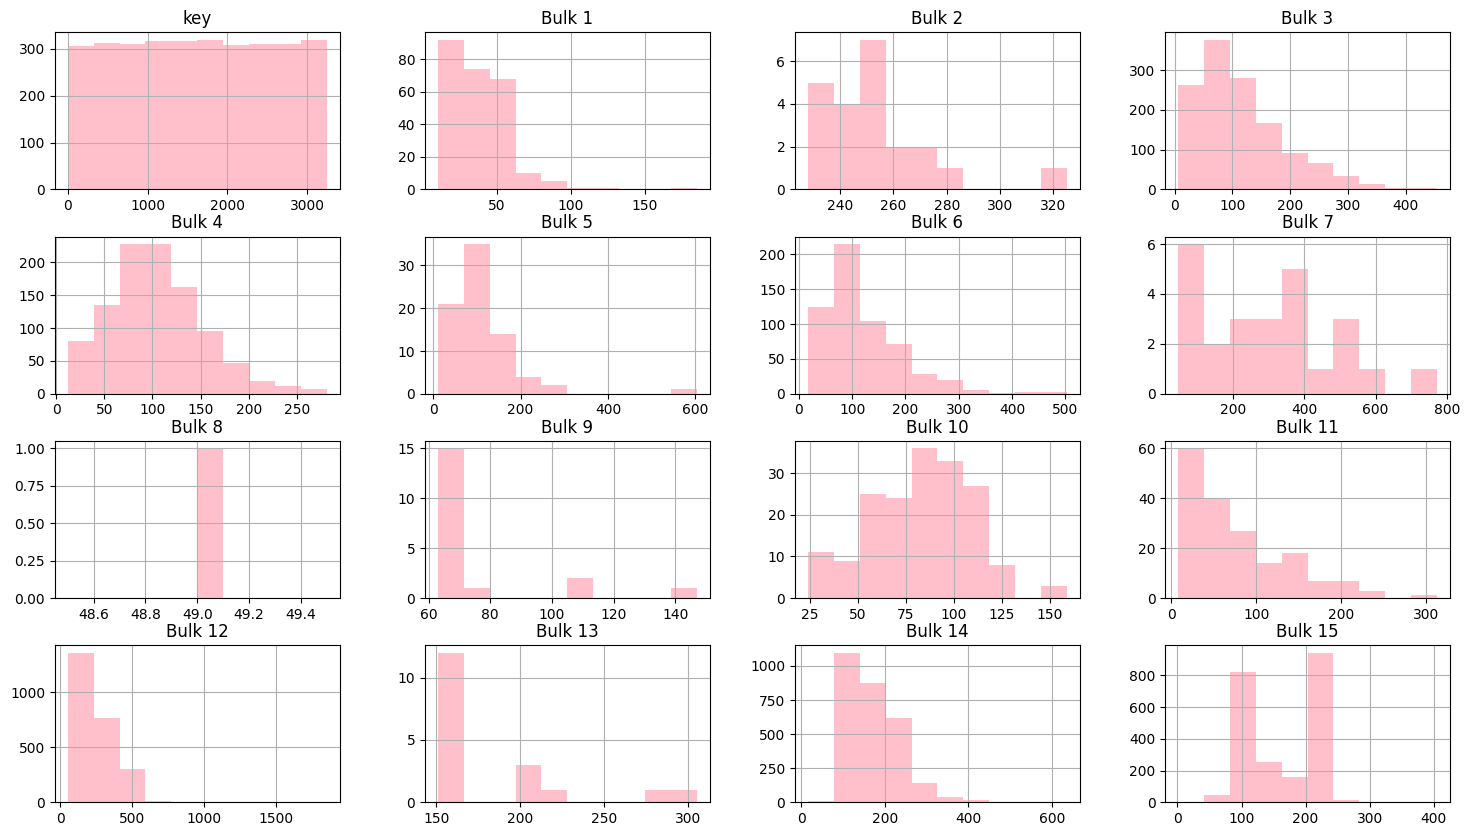

In [13]:
data_bulk.hist(figsize=(18, 10), color = 'pink');

явных аномальных данных при первичном анализе не выявлено

Проверим, нет ли таких циклов, где ничего не добавлялось:

In [14]:
data_bulk['sum'] = data_bulk.sum(axis = 1) - data_bulk['key']

In [15]:
data_bulk['sum'].isnull().sum()

0

### данные о подаче сыпучих материалов (время) (data_bulk_time.csv))

In [16]:
data_bulk_time = load_file('data_bulk_time.csv')
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Данные о времени, в которое было произведено добавление материалов использовать для построения модели не будем

### данные о продувке сплава газом (data_gas.csv))

In [17]:
data_gas = load_file('data_gas.csv')
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [18]:
# проверим данные на наличие явных дубликатов
data_gas.duplicated().sum()

0

In [19]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


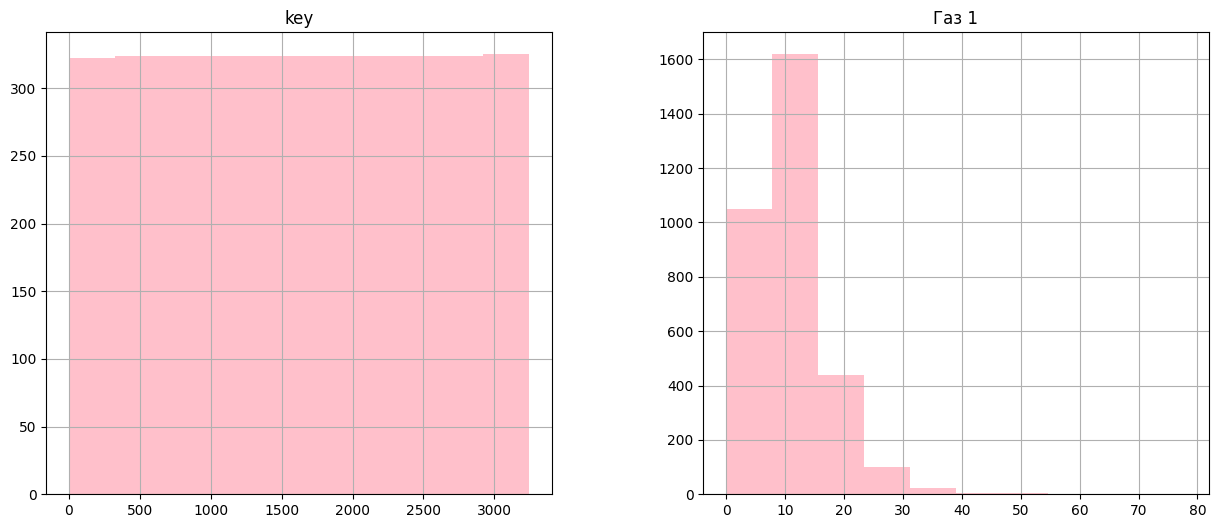

In [20]:
data_gas.hist(figsize=(15, 6), color = 'pink');

явных аномальных данных при первичном анализе не выявлено

###  результаты измерения температуры (data_temp.csv)

In [21]:
data_temp = load_file('data_temp.csv')
data_temp.tail()

,key,Время замера,Температура
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


In [22]:
# проверим данные на наличие явных дубликатов
data_temp.duplicated().sum()

0

In [23]:
data_temp.groupby(['key']).count() 

,Время замера,Температура
key,,
1,5,5
2,6,6
3,5,5
4,3,3
5,2,2
...,...,...
3237,5,1
3238,3,1
3239,8,1


Для дальнейшего анализа нам потребуются первое и последнее измерение температуры по каждому циклу

In [24]:
agg_func_selection = {'Температура': ['first', 'last', 'count'], 'Время замера': ['first', 'last']}
data_temp_result = data_temp.groupby(['key']).agg(agg_func_selection)

In [25]:
# переименуем колонки для удобства дальнейшей работы
data_temp_result.columns = data_temp_result.columns.map('_'.join)

In [26]:
data_temp_result.columns

Index(['Температура_first', 'Температура_last', 'Температура_count',
       'Время замера_first', 'Время замера_last'],
      dtype='object')

In [27]:
# возьмем только те циклы, для которых есть количество измерений температуры больше одного
data_temp_result = data_temp_result[data_temp_result['Температура_count'] != 1]

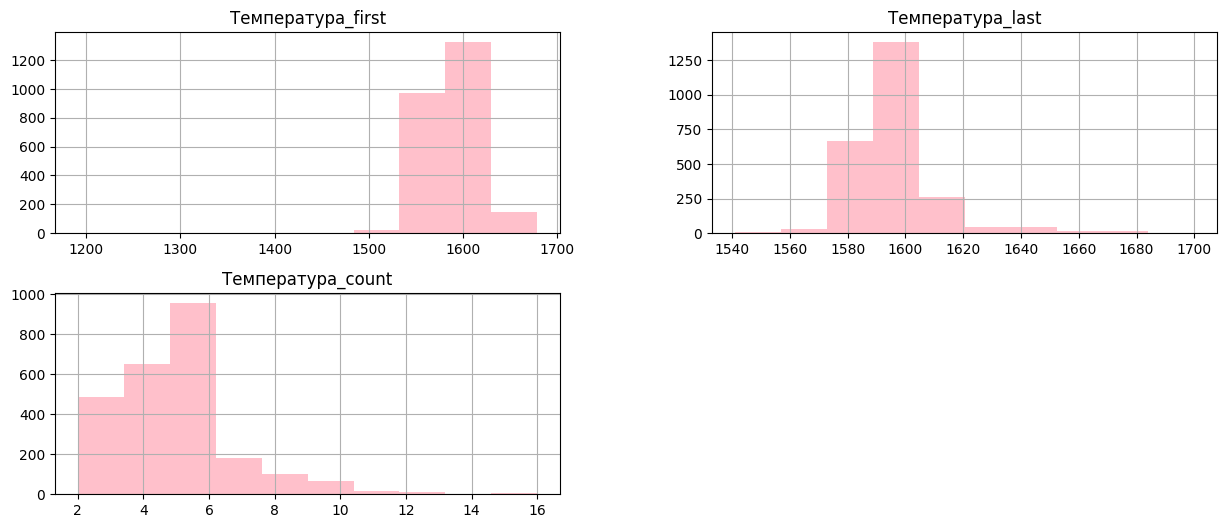

In [28]:
data_temp_result.hist(figsize=(15, 6), color = 'pink');

In [29]:
data_temp_result.describe()

,Температура_first,Температура_last,Температура_count
count,2475.000000,2475.000000,2475.000000
mean,1588.402020,1595.336162,4.955556
std,29.243044,16.023153,1.807323
min,1191.000000,1541.000000,2.000000
25%,1572.000000,1587.000000,4.000000
50%,1588.000000,1593.000000,5.000000
75%,1605.000000,1599.000000,6.000000
max,1679.000000,1700.000000,16.000000


мы видим, что при первой проверке присутствуют слишком низкие значения температуры, при дальнейшей обработке данных уберем циклы, в которых первая и последняя температуры ниже 1400

###  данные о проволочных материалах (объём) (data_wire.csv)

In [30]:
data_wire = load_file('data_wire.csv')
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# проверим данные на наличие явных дубликатов
data_wire.duplicated().sum()

0

In [32]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Проверим, нет ли таких циклов, где ничего не добавлялось:

In [33]:
data_wire['sum'] = data_wire.sum(axis = 1) - data_wire['key']

In [34]:
data_wire['sum'].isnull().sum()

0

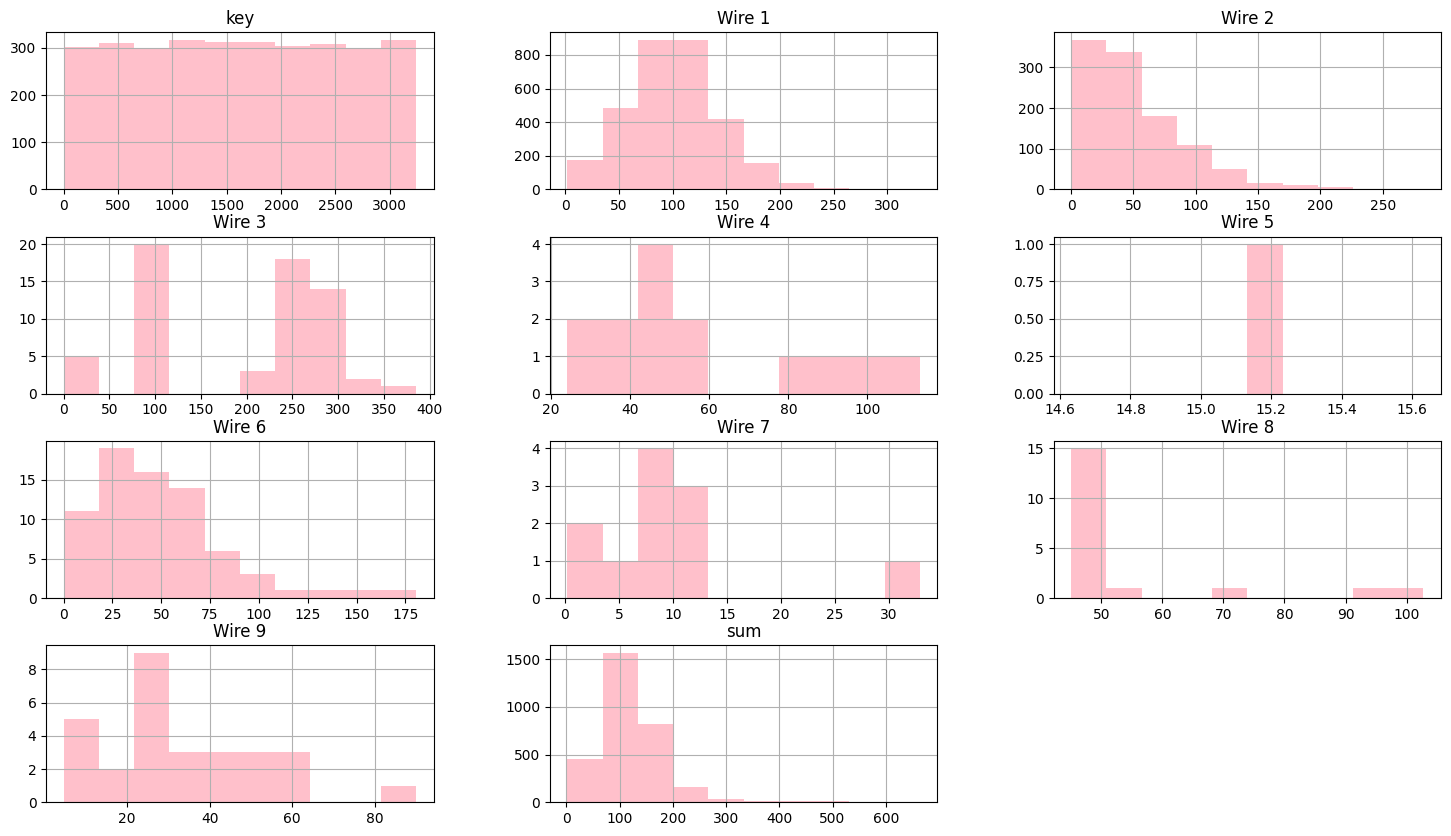

In [35]:
data_wire.hist(figsize=(18, 10), color = 'pink');

явных аномальных данных при первичном анализе не выявлено

###  данные о проволочных материалах (время) (data_wire_time.csv)

In [36]:
data_wire_time = load_file('data_wire_time.csv')
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Данные о времени, в которое было произведено добавление материалов использовать для построения модели не будем

## 2. Подробный план работ

1. Проведем предварительный анализ данных:
- проверим пропуски и дубликаты
- проверим наличие анамалий в данных на основании статистик и гистограмм
2. Объединим таблицы по inner join по ключу (key), чтобы отсеять стадии, которые не проходят полный цикл
3. Удалим из датасета аномальные данные, обнаруженные при первичном анализе
4. Создадим новые признаки на основе имеющихся данных:
 - работа (мощность, умноженная на время возвейдствия)
 - полная мощность (корень квадратный из суммы квадратов активной и реактивной мощностей)
 - время между первым и последним замером температуры
5. Построим confusion matrix для проверки корреляции признаков
6. Раздели данные на тренировочную(75%) и тестовую(25%) выборки
7. Для анализа возьмем 3 модели:
- Линейная регрессия
- RandomForest
- Catboost
8. Проведем подбор гиперпараметров для моделей
9. Выберем модель с наилучшим значением MAE на кросс-валидации и проверим ее на тестовой выборке
10. Сравним качество с константной моделью
11. Сделаем вывод
 

# 3. Предобработка данных

### 3.1 Удаление аномальных данных

**данные об электродах**

In [37]:
#найдем в каком цикле рективная мощность принимала отрицательные значения и удалим весь цикл
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


In [38]:
data_arc.query('key == 2116')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


In [39]:
data_arc = data_arc.query('key != 2116')

In [40]:
data_arc.query('key == 2116')

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность


**данные о температуре**

In [41]:
data_temp_result.head()

,Температура_first,Температура_last,Температура_count,Время замера_first,Время замера_last
key,,,,,
1,1571.0,1613.0,5,2019-05-03 11:16:18,2019-05-03 11:30:39
2,1581.0,1602.0,6,2019-05-03 11:37:27,2019-05-03 11:59:12
3,1596.0,1599.0,5,2019-05-03 12:13:17,2019-05-03 12:34:57
4,1601.0,1625.0,3,2019-05-03 12:52:57,2019-05-03 12:59:25
5,1576.0,1602.0,2,2019-05-03 13:23:19,2019-05-03 13:36:01


In [42]:
#найдем в каком цикле температура принимает значения меньше 1400
data_temp_result[data_temp_result['Температура_first'] < 1400] 

,Температура_first,Температура_last,Температура_count,Время замера_first,Время замера_last
key,,,,,
867,1191.0,1599.0,6,2019-06-04 14:21:00,2019-06-04 14:57:17
1214,1208.0,1591.0,16,2019-06-16 05:32:00,2019-06-16 06:14:45
1619,1218.0,1590.0,5,2019-06-30 11:03:54,2019-06-30 11:21:54
2052,1227.0,1592.0,5,2019-07-21 14:51:40,2019-07-21 15:24:06


In [43]:
# оставим только значения выше 1400
data_temp_result = data_temp_result[data_temp_result['Температура_first'] > 1400] 

### 3.2 Генерация новых признаков

Из данных об электродах возьмем информацию о количестве подогревов на каждом цикле, суммарное воздействие (сумма произведений полной мощности на время воздействия), среднюю полную мощность для каждого цикла 

In [44]:
# рассчитаем полную мощность для каждой операции как корень квадратный из суммы квадратов активной и 
# реактивной мощностей
data_arc['Полная_мощность'] = (data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)**0.5

In [45]:
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

In [46]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])

In [47]:
data_arc['Длительность'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.total_seconds()

In [48]:

data_arc['Работа'] = data_arc['Длительность'] * data_arc['Полная_мощность']

In [49]:
data_arc.head(6)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная_мощность,Длительность,Работа
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228.0,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185.0,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172.0,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365.0,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148.0,119.471318
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,0.521549,137.0,71.452170


In [50]:
agg_func_selection = {'Работа': ['sum', 'count'], 'Полная_мощность': ['mean']}
data_arc_result = data_arc.groupby(['key']).agg(agg_func_selection)

In [51]:
data_arc_result.head()

Работа       Полная_мощность
             sum count            mean
key                                   
1    1442.377754     5        1.165279
2     881.233565     4        0.912304
3     525.066777     5        0.597907
4     796.911309     4        0.953741
5    1199.137958     4        1.008939

In [52]:
#для удобства дальнейшей работы переименуем столбцы
data_arc_result.columns = data_arc_result.columns.map('_'.join)

Также в качестве дополнительного признака возьмем время между первым и последним замером температуры

In [53]:
# изменим тип данных о времени на datetime
data_temp_result['Время замера_first'] = pd.to_datetime(data_temp_result['Время замера_first'])
data_temp_result['Время замера_last'] = pd.to_datetime(data_temp_result['Время замера_last'])

In [54]:
data_temp_result['Интервал'] = (data_temp_result['Время замера_last'] - data_temp_result['Время замера_first']).dt.total_seconds()

In [55]:
data_temp_result.head()

,Температура_first,Температура_last,Температура_count,Время замера_first,Время замера_last,Интервал
key,,,,,,
1,1571.0,1613.0,5,2019-05-03 11:16:18,2019-05-03 11:30:39,861.0
2,1581.0,1602.0,6,2019-05-03 11:37:27,2019-05-03 11:59:12,1305.0
3,1596.0,1599.0,5,2019-05-03 12:13:17,2019-05-03 12:34:57,1300.0
4,1601.0,1625.0,3,2019-05-03 12:52:57,2019-05-03 12:59:25,388.0
5,1576.0,1602.0,2,2019-05-03 13:23:19,2019-05-03 13:36:01,762.0


### 3.3 Объединение данных в одну таблицу

Для дальнейшей работы объединим исходные таблицы по inner join по ключу (key), чтобы отсеять стадии, которые не проходят полный цикл. Таблицы с информацией о времени подачи мтериалов в таблицу включать не будем.

In [56]:
# объединим таблицы с данными о температуре и данные об электродах
df = data_temp_result.merge(data_arc_result, left_on='key', right_on='key')
df.head()

,Температура_first,Температура_last,Температура_count,Время замера_first,Время замера_last,Интервал,Работа_sum,Работа_count,Полная_мощность_mean
key,,,,,,,,,
1,1571.0,1613.0,5,2019-05-03 11:16:18,2019-05-03 11:30:39,861.0,1442.377754,5,1.165279
2,1581.0,1602.0,6,2019-05-03 11:37:27,2019-05-03 11:59:12,1305.0,881.233565,4,0.912304
3,1596.0,1599.0,5,2019-05-03 12:13:17,2019-05-03 12:34:57,1300.0,525.066777,5,0.597907
4,1601.0,1625.0,3,2019-05-03 12:52:57,2019-05-03 12:59:25,388.0,796.911309,4,0.953741
5,1576.0,1602.0,2,2019-05-03 13:23:19,2019-05-03 13:36:01,762.0,1199.137958,4,1.008939


In [57]:
# добавим данные о подаче сыпучих материалов
df = df.merge(data_bulk, left_on='key', right_on='key')
df.head()

,key,Температура_first,Температура_last,Температура_count,Время замера_first,Время замера_last,Интервал,Работа_sum,Работа_count,Полная_мощность_mean,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum
0,1,1571.0,1613.0,5,2019-05-03 11:16:18,2019-05-03 11:30:39,861.0,1442.377754,5,1.165279,...,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,553.0
1,2,1581.0,1602.0,6,2019-05-03 11:37:27,2019-05-03 11:59:12,1305.0,881.233565,4,0.912304,...,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,582.0
2,3,1596.0,1599.0,5,2019-05-03 12:13:17,2019-05-03 12:34:57,1300.0,525.066777,5,0.597907,...,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,544.0
3,4,1601.0,1625.0,3,2019-05-03 12:52:57,2019-05-03 12:59:25,388.0,796.911309,4,0.953741,...,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,595.0
4,5,1576.0,1602.0,2,2019-05-03 13:23:19,2019-05-03 13:36:01,762.0,1199.137958,4,1.008939,...,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,584.0


In [58]:
# добавим данные о продувке сплава газом
df = df.merge(data_gas, left_on='key', right_on='key')
df.head()

,key,Температура_first,Температура_last,Температура_count,Время замера_first,Время замера_last,Интервал,Работа_sum,Работа_count,Полная_мощность_mean,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum,Газ 1
0,1,1571.0,1613.0,5,2019-05-03 11:16:18,2019-05-03 11:30:39,861.0,1442.377754,5,1.165279,...,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,553.0,29.749986
1,2,1581.0,1602.0,6,2019-05-03 11:37:27,2019-05-03 11:59:12,1305.0,881.233565,4,0.912304,...,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,582.0,12.555561
2,3,1596.0,1599.0,5,2019-05-03 12:13:17,2019-05-03 12:34:57,1300.0,525.066777,5,0.597907,...,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,544.0,28.554793
3,4,1601.0,1625.0,3,2019-05-03 12:52:57,2019-05-03 12:59:25,388.0,796.911309,4,0.953741,...,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,595.0,18.841219
4,5,1576.0,1602.0,2,2019-05-03 13:23:19,2019-05-03 13:36:01,762.0,1199.137958,4,1.008939,...,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,584.0,5.413692


In [59]:
# добавим данные о проволочных материалах 
df = df.merge(data_wire, left_on='key', right_on='key')
df.head()

,key,Температура_first,Температура_last,Температура_count,Время замера_first,Время замера_last,Интервал,Работа_sum,Работа_count,Полная_мощность_mean,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,sum_y
0,1,1571.0,1613.0,5,2019-05-03 11:16:18,2019-05-03 11:30:39,861.0,1442.377754,5,1.165279,...,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.059998
1,2,1581.0,1602.0,6,2019-05-03 11:37:27,2019-05-03 11:59:12,1305.0,881.233565,4,0.912304,...,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.052315
2,3,1596.0,1599.0,5,2019-05-03 12:13:17,2019-05-03 12:34:57,1300.0,525.066777,5,0.597907,...,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.160157
3,4,1601.0,1625.0,3,2019-05-03 12:52:57,2019-05-03 12:59:25,388.0,796.911309,4,0.953741,...,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.063515
4,5,1576.0,1602.0,2,2019-05-03 13:23:19,2019-05-03 13:36:01,762.0,1199.137958,4,1.008939,...,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.352796


In [60]:
df['Wire 5'].value_counts()

Series([], Name: Wire 5, dtype: int64)

In [61]:
df['Bulk 8'].value_counts()

49.0    1
Name: Bulk 8, dtype: int64

Мы видим, что материалы Bulk 8 и Wire 5 добавлялись всего в одном цикле, поэтому такие признаки будут не достаточно информативны, удалим их из нашего датасета

In [61]:
df = df.drop(["Wire 5", "Bulk 8"], axis = 1)

### 3.3 Проверим корреляцию признаков

In [62]:
df.isna().shape

(2324, 35)

In [63]:
# заменим пропуски на нули
df = df.fillna(0)

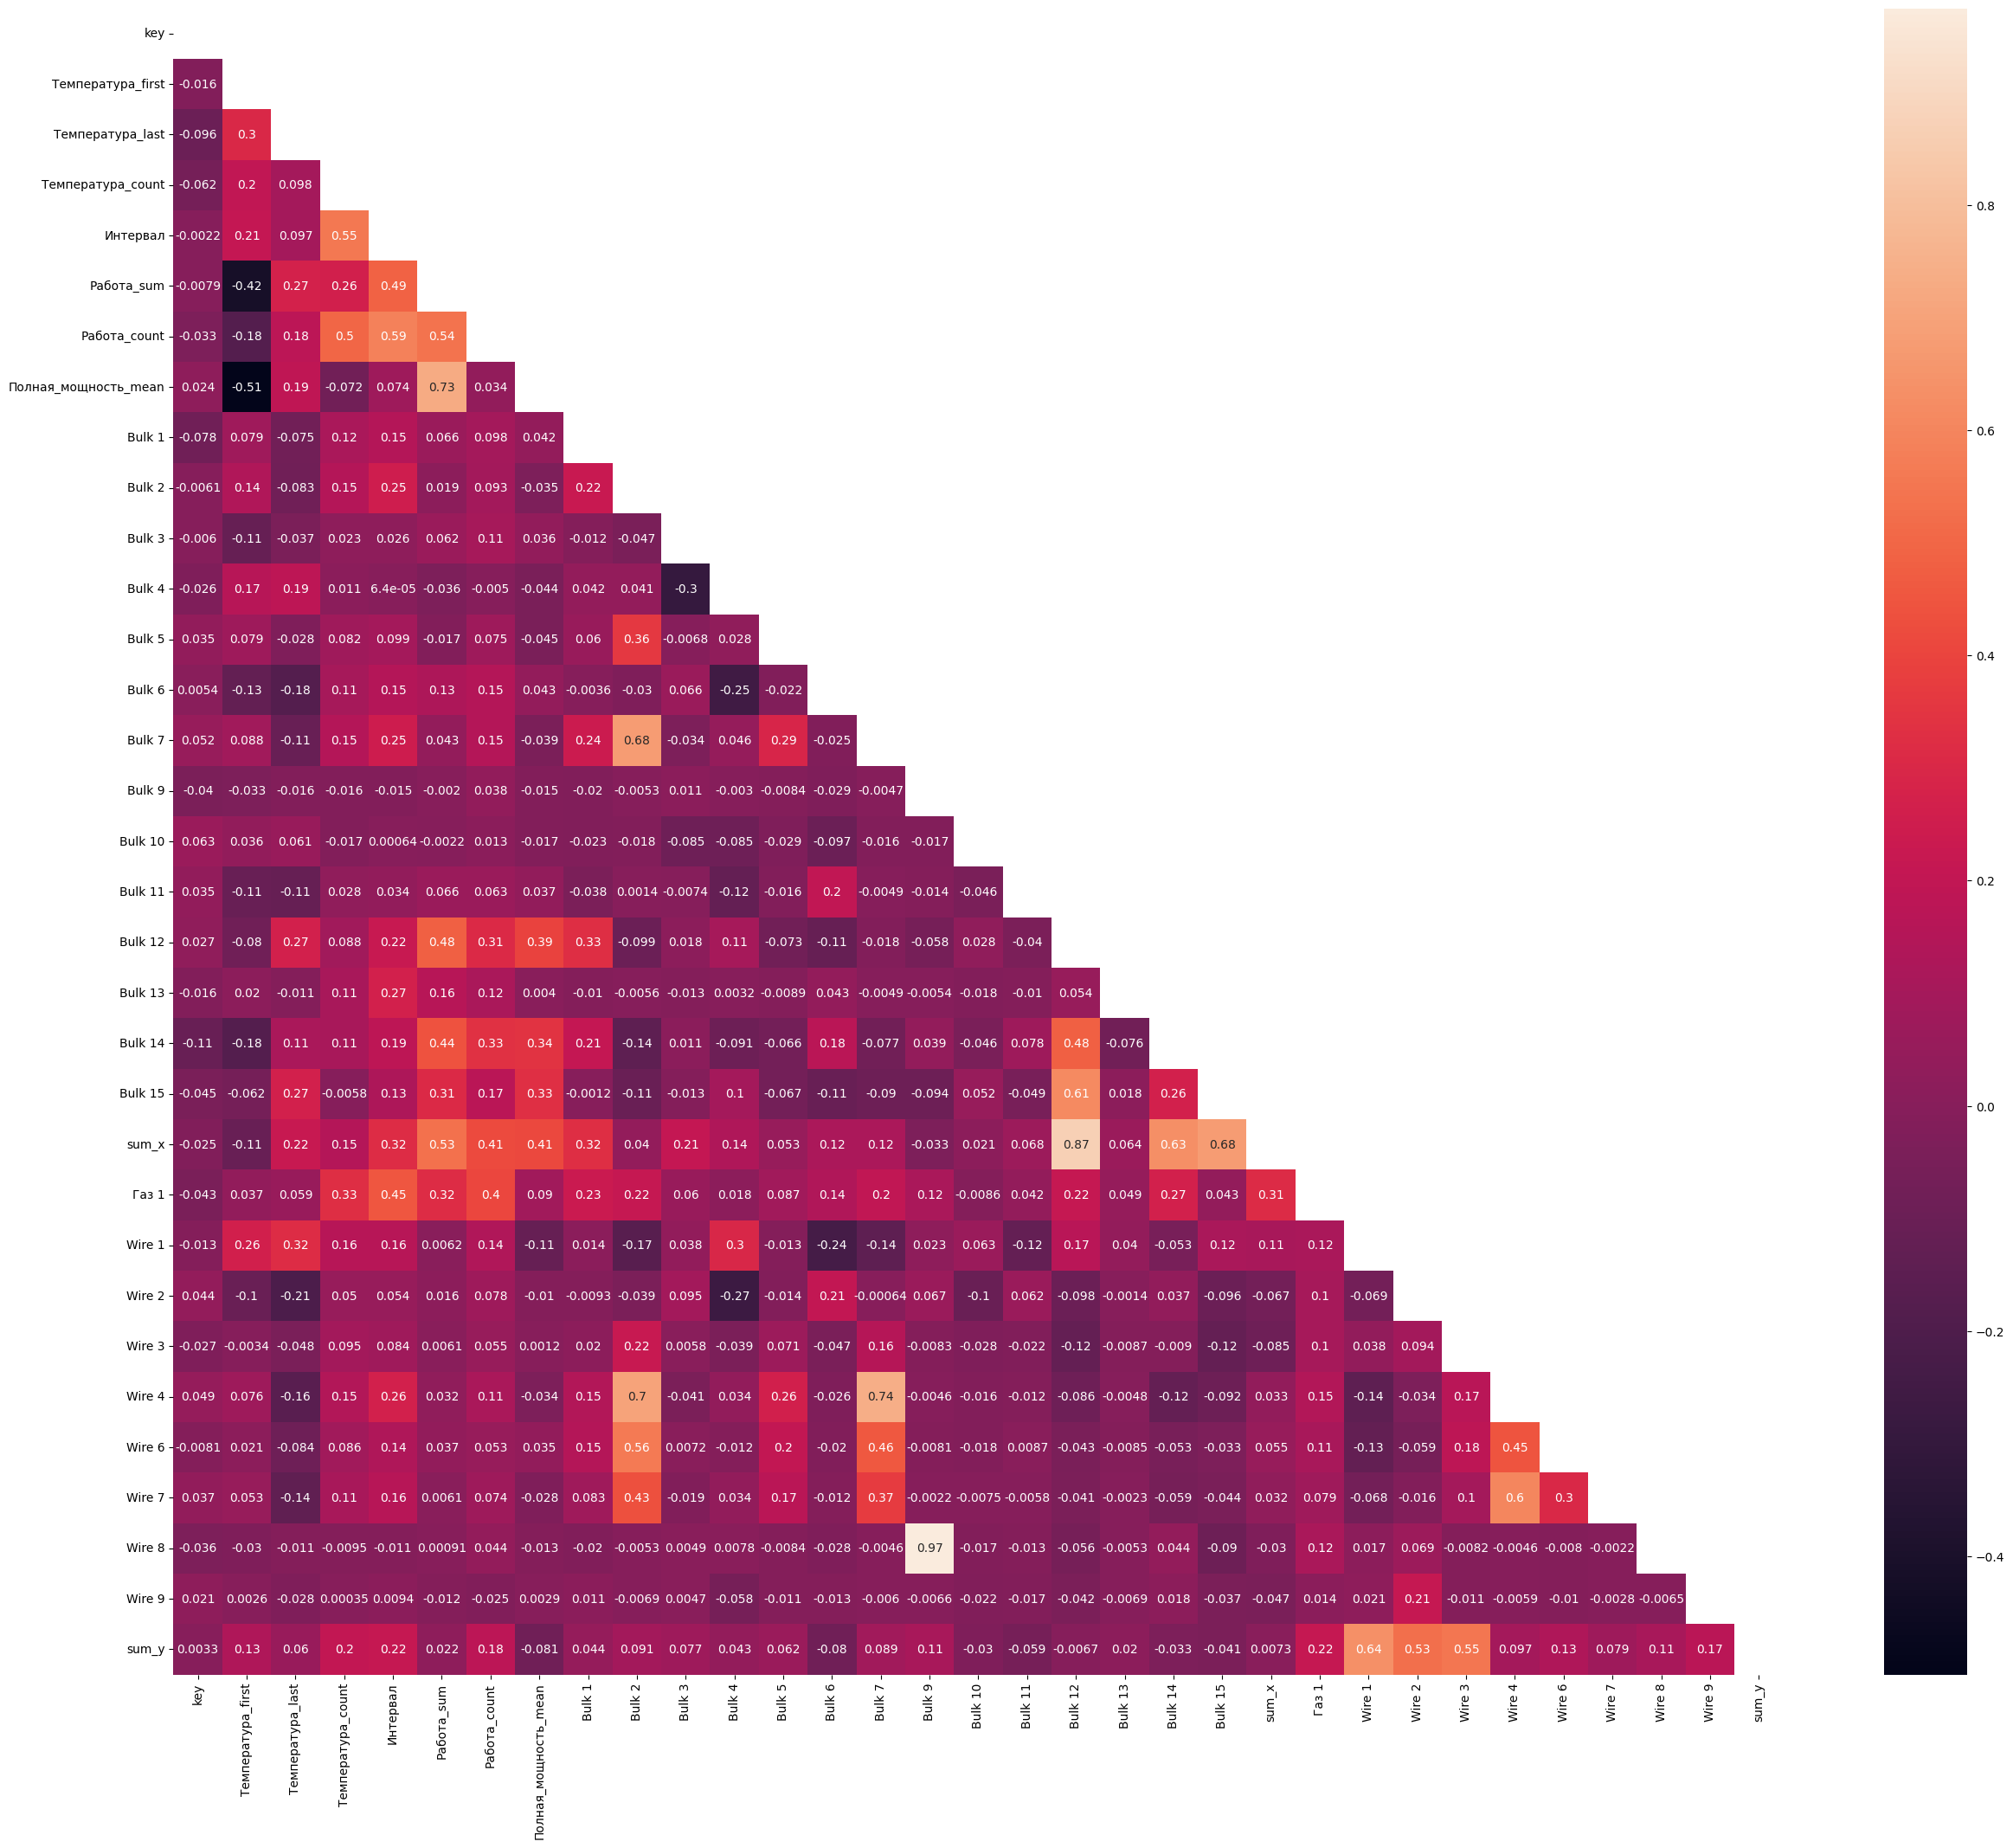

In [64]:
plt.rcParams['figure.figsize']=(30,25)

corr = df.corr()
g = sns.heatmap(corr, square = False, annot=True, mask=np.triu(np.ones_like(corr, dtype=bool)))

Их графика видно, что наиболее скоррелированы некоторые добавки сыпучих и проволочных материалов. Поскольку это связано с особенностями технологии, то убрать мы эти данные не можем. Кроме того высокую корреляцию дают суммарные объемы добавок. При обучении удалим их из датасета, поскольку данные об объеме у нас есть отдельно по всем добавкам

### 3.4 Выделим выборки

In [65]:
df.head()

,key,Температура_first,Температура_last,Температура_count,Время замера_first,Время замера_last,Интервал,Работа_sum,Работа_count,Полная_мощность_mean,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,sum_y
0,1,1571.0,1613.0,5,2019-05-03 11:16:18,2019-05-03 11:30:39,861.0,1442.377754,5,1.165279,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,60.059998
1,2,1581.0,1602.0,6,2019-05-03 11:37:27,2019-05-03 11:59:12,1305.0,881.233565,4,0.912304,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,96.052315
2,3,1596.0,1599.0,5,2019-05-03 12:13:17,2019-05-03 12:34:57,1300.0,525.066777,5,0.597907,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,91.160157
3,4,1601.0,1625.0,3,2019-05-03 12:52:57,2019-05-03 12:59:25,388.0,796.911309,4,0.953741,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,89.063515
4,5,1576.0,1602.0,2,2019-05-03 13:23:19,2019-05-03 13:36:01,762.0,1199.137958,4,1.008939,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,98.352796


Для обучения модели уберем из таблицы сведения о начальном (Время замера_first) и конечном (Время замера_last) времени замера, номер цикла (key), суммарных объемах добавки материалов и целевом признаке

In [66]:
X = df.drop(["Температура_last", "Время замера_first", "Время замера_last", "key", "sum_x", "sum_y"], axis = 1)
y = df["Температура_last"]

In [67]:
X.head()

,Температура_first,Температура_count,Интервал,Работа_sum,Работа_count,Полная_мощность_mean,Bulk 1,Bulk 2,Bulk 3,Bulk 4,...,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1571.0,5,861.0,1442.377754,5,1.165279,0.0,0.0,0.0,43.0,...,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,6,1305.0,881.233565,4,0.912304,0.0,0.0,0.0,73.0,...,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,5,1300.0,525.066777,5,0.597907,0.0,0.0,0.0,34.0,...,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,3,388.0,796.911309,4,0.953741,0.0,0.0,0.0,81.0,...,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,2,762.0,1199.137958,4,1.008939,0.0,0.0,0.0,78.0,...,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
features_train, features_test, target_train, target_test = train_test_split(
    X, y, test_size=0.25, random_state=151122)

In [69]:
# отмасштабируем данные
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

## 4. Обучение модели 

### 4.1 Линейная регрессия

In [70]:
model = LinearRegression()
score = cross_val_score(model, features_train, target_train, scoring = 'neg_mean_absolute_error', cv=5)
mae_lr = np.mean(np.abs(score))
print('MAE: {:.2f}'.format(mae_lr))

MAE: 5.98


Для удобства сравнительного анализа создадим таблицу с названием модели и значением MAE

In [71]:
metrics_df = pd.DataFrame(columns=['model', 'MAE'])

In [72]:
metrics_df = metrics_df.append({
    'model': 'LinearRegression',
    'MAE': mae_lr
}, ignore_index=True)

metrics_df

C:\Users\Lenin\AppData\Local\Temp\ipykernel_19956\1783177612.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,MAE
0,LinearRegression,5.980916


### 4.2 RandomForest

In [73]:
model = RandomForestRegressor()
grid = { 
    'n_estimators': [200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [3, 4, 5, 6, 7]
}
Grid_RF = GridSearchCV(estimator=model, param_grid = grid, cv = 5, scoring='neg_mean_absolute_error')

In [75]:
Grid_RF.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 300, 400, 500]},
             scoring='neg_mean_absolute_error')

In [76]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_RF.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_RF.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_RF.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=7, max_features='sqrt', n_estimators=300)

 The best score across ALL searched params:
 -6.6154349853799985

 The best parameters across ALL searched params:
 {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 300}


In [77]:
metrics_df = metrics_df.append({
    'model': 'RandomForestRegressor',
    'MAE': abs(Grid_RF.best_score_)
}, ignore_index=True)

metrics_df

C:\Users\Lenin\AppData\Local\Temp\ipykernel_18464\4223972178.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,MAE
0,LinearRegression,5.980916
1,RandomForestRegressor,6.615435


### 4.3 Catboost

In [78]:
model = CatBoostRegressor(iterations=100)
model.fit(features_train, target_train)
score = cross_val_score(model, features_train, target_train, scoring = 'neg_mean_absolute_error', cv=5)
print(f'MAE: {score}')

Learning rate set to 0.290606
0:	learn: 10.3546328	total: 138ms	remaining: 13.6s
1:	learn: 9.7995652	total: 144ms	remaining: 7.05s
2:	learn: 9.3893289	total: 151ms	remaining: 4.89s
3:	learn: 9.0259571	total: 156ms	remaining: 3.75s
4:	learn: 8.7241576	total: 163ms	remaining: 3.1s
5:	learn: 8.4335623	total: 170ms	remaining: 2.67s
6:	learn: 8.2298469	total: 177ms	remaining: 2.35s
7:	learn: 8.0712189	total: 185ms	remaining: 2.13s
8:	learn: 7.9548045	total: 195ms	remaining: 1.97s
9:	learn: 7.8449923	total: 203ms	remaining: 1.82s
10:	learn: 7.6577477	total: 213ms	remaining: 1.72s
11:	learn: 7.5636669	total: 219ms	remaining: 1.6s
12:	learn: 7.5133978	total: 230ms	remaining: 1.54s
13:	learn: 7.4558451	total: 235ms	remaining: 1.44s
14:	learn: 7.3321749	total: 244ms	remaining: 1.38s
15:	learn: 7.3002729	total: 249ms	remaining: 1.31s
16:	learn: 7.2098390	total: 259ms	remaining: 1.26s
17:	learn: 7.1469986	total: 264ms	remaining: 1.2s
18:	learn: 7.0466683	total: 269ms	remaining: 1.15s
19:	learn: 6.

In [79]:
model = CatBoostRegressor(iterations=50)
grid = {'learning_rate': [0.03, 0.1, 0.28, 0.5],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
Grid_CBR = GridSearchCV(estimator=model, param_grid = grid, cv = 5, n_jobs=-1, scoring='neg_mean_absolute_error')

In [80]:
Grid_CBR.fit(features_train, target_train, verbose = False)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000023EAC782970>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 10], 'l2_leaf_reg': [1, 3, 5, 7, 9],
                         'learning_rate': [0.03, 0.1, 0.28, 0.5]},
             scoring='neg_mean_absolute_error')

In [81]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBR.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBR.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 -5.968386148251206

 The best parameters across ALL searched params:
 {'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 0.5}


In [82]:
metrics_df = metrics_df.append({
    'model': 'CatBoostRegressor',
    'MAE': abs(Grid_CBR.best_score_)
}, ignore_index=True)

metrics_df

C:\Users\Lenin\AppData\Local\Temp\ipykernel_18464\2680440015.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


,model,MAE
0,LinearRegression,5.980916
1,RandomForestRegressor,6.615435
2,CatBoostRegressor,5.968386


## 5 Проверка модели на тестовых данных

Выведем полученную сравнительную таблицу

In [83]:
metrics_df

,model,MAE
0,LinearRegression,5.980916
1,RandomForestRegressor,6.615435
2,CatBoostRegressor,5.968386


Наилучшее качество по метрике MAE показаламодель CatBoostRegressor со следующими параметрами: 'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 0.5. Проверим ее качество на отложенной тестовой выборке

In [84]:
pred = Grid_CBR.predict(features_test)
mae = mean_absolute_error(target_test, pred)
print('MAE: {:.2f}'.format(mae))

MAE: 5.95


## 6 Сравнение с константной моделью

In [85]:
model_dummy = DummyRegressor()
model_dummy.fit(features_train, target_train)
pred = model_dummy.predict(target_test)
mae = mean_absolute_error(target_test, pred)
print('MAE: {:.2f}'.format(mae))

MAE: 8.22


Модель CatBoostRegressor с подбором гиперпараметров превзошла константную модель на 2.27

## Вывод

Целью данного проекта было построение модели, которая предскажет температуру стали. В качестве целевой метрики использовалась MAE. В ходе проделанной работы были исследованы 3 модели:
* Линейная регрессия
* RandomForest
* Catboost
Наилучшее качество на кроссвалидации показала модель CatBoostRegressor со следующими параметрами: 'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 0.5. При проверке данной модели на тестовой выборке значение MAE 5.95, что 2.27 лучше константной модели.

# Отчет

## 1. Сравнение с планом

В ходе проведения работы был изменен порядок выполнения некоторых пунктов в плане. Согласно плану после предобработки данных необходимо было объединить таблицы, после чего обработать аномальные данные и создать новые признаки. Однако в процессе работы над проектом было принято решение сначала удалить аномальные данные и создать новые признаки, после чего уже объединять таблицы. Это было обусловлено тем, что при объединении часть аномальных признаков, могла "потеряться", например отрицательное значение мощности, поскольку в итоговую таблицу были включены только признаки на основании полной рассчитанной мощности. Кроме того, в ходе выполнения работы были добавлены новые прзнаки, которые не были учтены в плане: количество замеров температуры и количество раз подачи напряжения.

## 2. Ключевые шаги и трудности

Основные ключевые шаги в проекте: анализ данных, предобработка данных, обучение моделей, тестирование на финальной модели. Основныые трудности возникли при предобработке данных, поскольку для решения данной задачи пришлось разобраться с технологическими особенностями при обработке стали

## 3. Описание финальной модели

Наилучшее качество на кроссвалидации показала модель градиентного бустинга CatBoostRegressor со следующими параметрами:
*  depth (глубина дерева): 4 
* l2_leaf_reg(коэффициент при члене регуляризации L2 функции потерь): 9
* learning_rate(скорость обучения): 0.5

В качестве исходных данных были взяты 5 таблиц:
* data_arc.csv — данные об электродах
* data_bulk.csv — данные о подаче сыпучих материалов (объём)
* data_gas.csv — данные о продувке сплава газом
* data_temp.csv — результаты измерения температуры
* data_wire.csv — данные о проволочных материалах (объём)
При предобработке данных были удалены аномальные значения (отрицательные значения мощности, значения температуры ниже 1400 градусов, циклы, в которых было только одно измерение температуры)

Для обучения модели были использованы следующие признаки:
* Температура_first - температура при первом измерении, при предобработке удалили аномальные значения ниже 1400 
* Bulk 1, Bulk 2, Bulk 3, Bulk 4,  Bulk 5, Bulk б, Bulk 7, Bulk 9, Bulk 10, Bulk 11, Bulk 12, Bulk 13, Bulk 14, Bulk 15 - в итоговые данные взяли все значения сыпучих материалов, кроме Bulk 8, поскольку он использовался только в одном цикле          
* Газ 1 
* Wire 1, Wire 2, Wire 3, Wire 4, Wire 6, Wire 7, Wire 8, Wire 9                
А также созданы следующие новые признаки:
* 1   Температура_count - количество замеров температуры  
* 2   Интервал - время между первым и последним замерами температуры 
* 3   Полная_мощность_mean - среднее значение полной мощности (полная мощность рассчитывается как корень квадратный из суммы квадратов активной и реактивной мощности). При предобработке данных о мощности удалены аномальные отрицательные значения 
* 4   Работа_sum - сумма произведений полной мощности на время нагрева
* 5   Работа_count - количество нагревов стали электродами 